<a href="https://colab.research.google.com/github/soconzan/2024-2-dl/blob/main/ResNet50%2BCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 시각화 함수

In [2]:
# 학습 정확도 및 손실 시각화 함수
import matplotlib.pyplot as plt

def plot_training_history(history):

    plt.figure(figsize=(14, 6))

    # 정확도
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')

    # 손실
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')

    # 레이아웃 자동 조정 및 출력
    plt.tight_layout()
    plt.show()
    print()

# 예측 결과 시각화 함수
import numpy as np

def plot_predictions(x_test, y_test, predictions, class_names, num_images=10):

    plt.figure(figsize=(25, 30))

    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(x_test[i])
        plt.xticks([])
        plt.yticks([])
        true_label = np.argmax(y_test[i])
        predicted_label = np.argmax(predictions[i])
        plt.xlabel(f"True: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}", fontsize=12)

        # 예측 확률 출력
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.barh(class_names, predictions[i], color='blue', height=0.2)
        plt.xlim([0, 1])
        plt.yticks(np.arange(len(class_names)), class_names, fontsize=12)
        plt.xlabel('Probability', fontsize=12)

    plt.tight_layout()
    plt.show()
    print()

### CIFAR-10 학습 데이터 로드

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


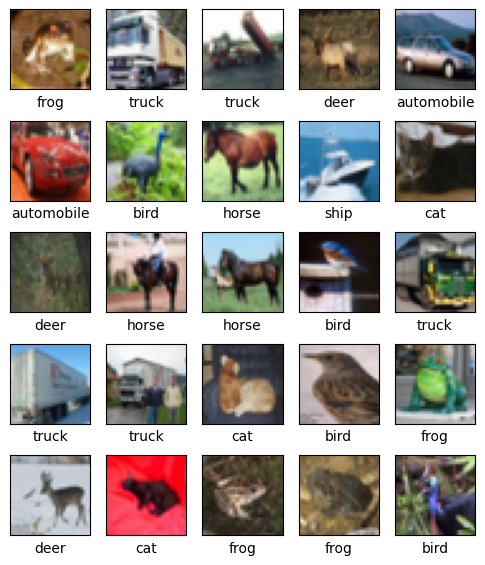

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# CIFAR-10 데이터셋 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 클래스 레이블
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 이미지 9개 시각화
plt.figure(figsize=(6,7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# 데이터 전처리 - 이미지 데이터 정규화 (0~255 범위의 값을 0~1로 변경)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 라벨을 One-hot 인코딩
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### 데이터 증강

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagen.fit(x_train)

---
### 1차 모델링
- ResNet50 모델 사용
- 사전 훈련 층 모두 고정

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 레이어 추가
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# 사전 훈련된 층 고정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ModelCheckpoint 설정
checkpoint = ModelCheckpoint('best_resnet50_cifar10_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.2124 - loss: 2.1947 - val_accuracy: 0.3046 - val_loss: 1.9208
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.3108 - loss: 1.9026 - val_accuracy: 0.3212 - val_loss: 1.8929
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3367 - loss: 1.8283 - val_accuracy: 0.3352 - val_loss: 1.8565
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3513 - loss: 1.7948 - val_accuracy: 0.3736 - val_loss: 1.7522
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3559 - loss: 1.7776 - val_accuracy: 0.3698 - val_loss: 1.7458
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3716 - loss: 1.7451 - val_accuracy: 0.3736 - val_loss: 1.7530
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3773 - loss: 1.7234 - val_accuracy: 0.3831 - val_loss: 1.7199
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3840 - loss: 1.7101 - val

### 1차 모델링 결과

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,750,368 (102.04 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2,108,438 (8.04 MB)

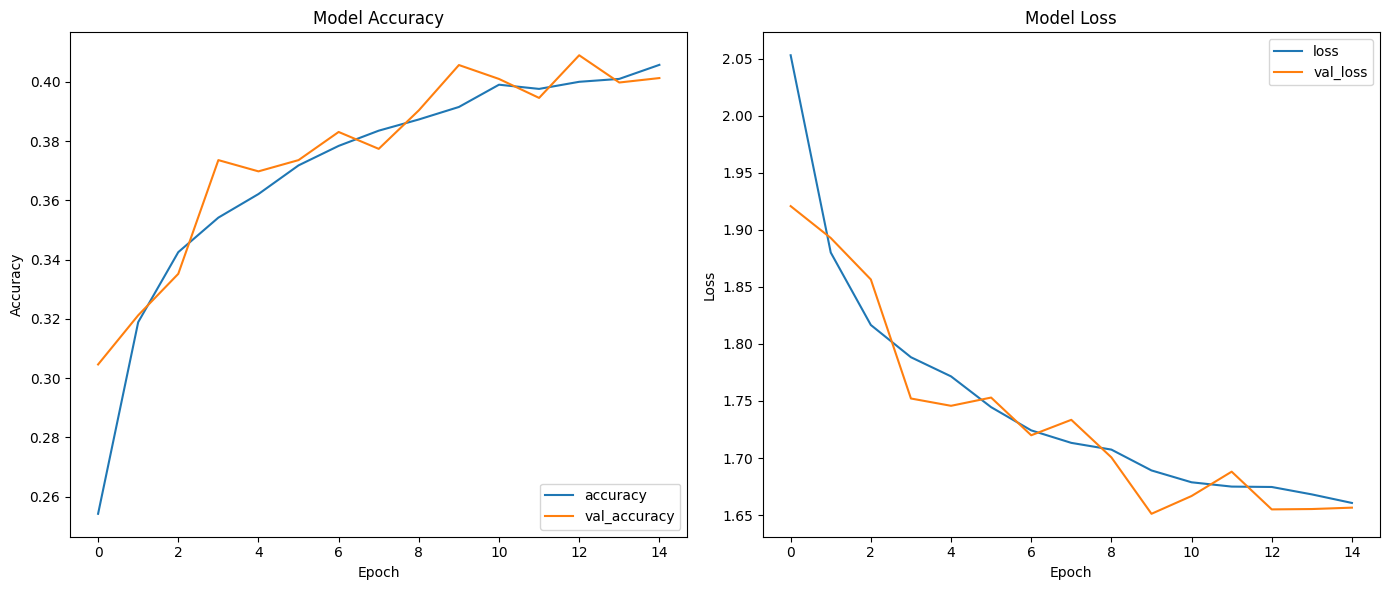

In [8]:
plot_training_history(history)

In [9]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print("=====================================")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4082 - loss: 1.6384
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4049 - loss: 1.6501

Train Loss: 1.6427271366119385
Train Accuracy: 0.40821999311447144
-------------------------------------
Test Loss: 1.6511017084121704
Test Accuracy: 0.4056999981403351


---
### 2차 모델링
- 사전 훈련 층 절반 고정, 나머지 반 학습

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 레이어 추가
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# 사전 훈련된 층 반은 고정
for layer in base_model.layers[:len(base_model.layers)//2]:
    layer.trainable = False
# 나머지 절반은 학습 가능하도록 설정
for layer in base_model.layers[len(base_model.layers)//2:]:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ModelCheckpoint 설정
checkpoint = ModelCheckpoint('best_resnet50_cifar10_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 49ms/step - accuracy: 0.3343 - loss: 1.9490 - val_accuracy: 0.1032 - val_loss: 2.3001
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - accuracy: 0.5322 - loss: 1.3397 - val_accuracy: 0.1000 - val_loss: 5.1275
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.5781 - loss: 1.2051 - val_accuracy: 0.1000 - val_loss: 75.0525
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.6090 - loss: 1.1128 - val_accuracy: 0.1001 - val_loss: 3.8483
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.6394 - loss: 1.0257 - val_accuracy: 0.1000 - val_loss: 23.2044
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.6574 - loss: 0.9681 - val_accuracy: 0.1165 - val_loss: 2.2794
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.6597 - loss: 0.9489 - val_accuracy: 0.1000 - val_loss: 24.0451
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.6951 - loss: 0.8598

### 2차 모델링 결과

In [11]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,474,720 (265.03 MB)

 Trainable params: 22,416,394 (85.51 MB)

 Non-trainable params: 2,225,536 (8.49 MB)

 Optimizer params: 44,832,790 (171.02 MB)

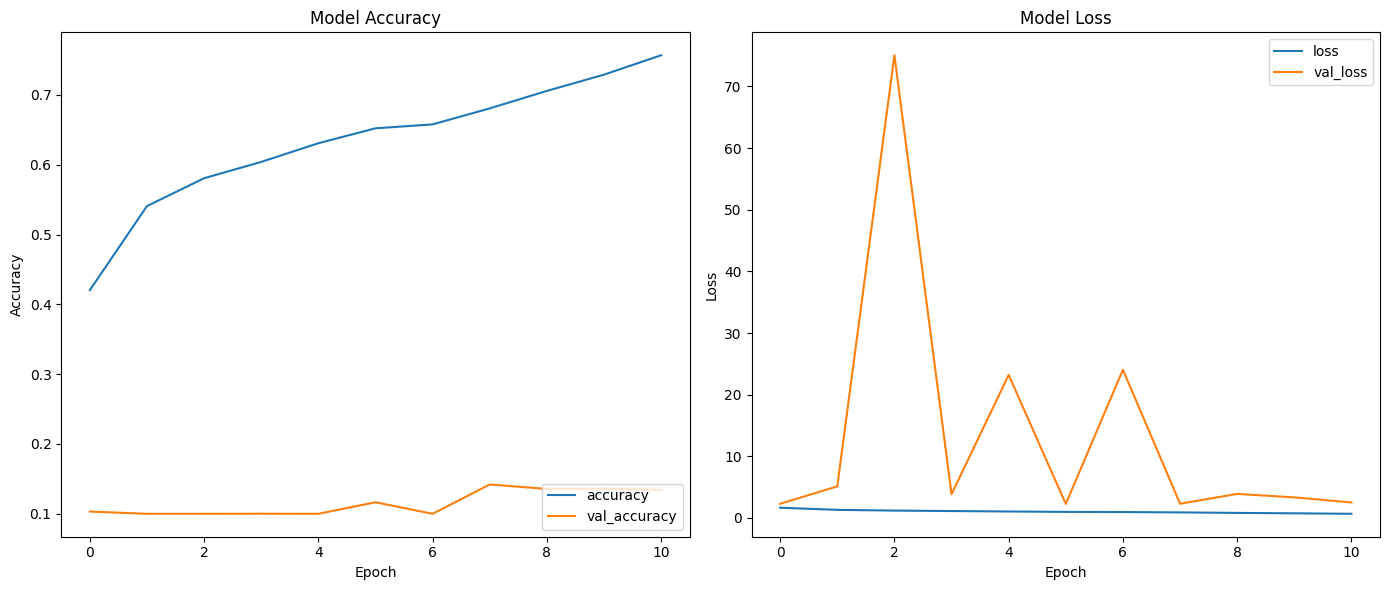

In [12]:
plot_training_history(history)

In [13]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print("=====================================")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.1157 - loss: 2.2802
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1132 - loss: 2.2809

Train Loss: 2.279271125793457
Train Accuracy: 0.11636000126600266
-------------------------------------
Test Loss: 2.279371738433838
Test Accuracy: 0.11649999767541885


---
### 3차 모델링
- 사전 훈련 층 모두 학습

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 레이어 추가
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# 사전 훈련된 층 모두 학습
for layer in base_model.layers:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ModelCheckpoint 설정
checkpoint = ModelCheckpoint('best_resnet50_cifar10_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 71ms/step - accuracy: 0.5310 - loss: 1.4715 - val_accuracy: 0.3731 - val_loss: 1.9323
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.7446 - loss: 0.7742 - val_accuracy: 0.7067 - val_loss: 0.9099
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.7671 - loss: 0.7072 - val_accuracy: 0.6839 - val_loss: 0.9702
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.7890 - loss: 0.6410 - val_accuracy: 0.7345 - val_loss: 0.8184
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.8350 - loss: 0.4968 - val_accuracy: 0.7196 - val_loss: 0.8807
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.8622 - loss: 0.4146 - val_accuracy: 0.7452 - val_loss: 0.7946
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.8763 - loss: 0.3741 - val_accuracy: 0.7170 - val_loss: 0.9253
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8334 - loss: 0.5085 -

### 3차 모델링 결과

In [15]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,819,552 (281.60 MB)

 Trainable params: 24,588,810 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,177,622 (187.60 MB)

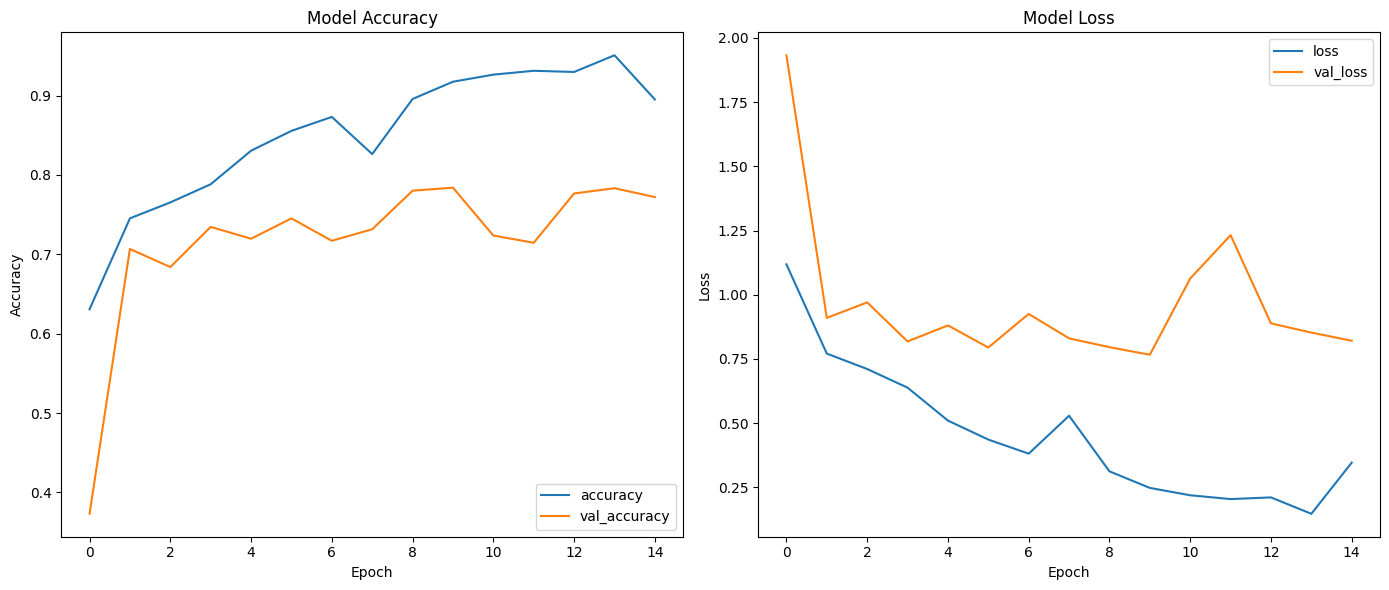

In [16]:
plot_training_history(history)

In [17]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print("=====================================")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9150 - loss: 0.2469
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7853 - loss: 0.7638

Train Loss: 0.25346124172210693
Train Accuracy: 0.9124400019645691
-------------------------------------
Test Loss: 0.7664867639541626
Test Accuracy: 0.7839000225067139


---
### 4차 모델링
- 학습률 스케줄링 설정 (과적합 방지)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 레이어 추가
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# 사전 훈련된 층 모두 학습
for layer in base_model.layers:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ModelCheckpoint 설정
checkpoint = ModelCheckpoint('best_resnet50_cifar10_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# 학습률 스케줄링 설정
def lr_schedule(epoch, lr):
    if epoch > 5:
        return lr * 0.5  # 에포크 5 이후 학습률을 절반으로 줄임
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 119s 85ms/step - accuracy: 0.5188 - loss: 1.5178 - val_accuracy: 0.3317 - val_loss: 2.5254 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 48ms/step - accuracy: 0.7401 - loss: 0.7771 - val_accuracy: 0.6789 - val_loss: 1.0070 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.7885 - loss: 0.6328 - val_accuracy: 0.7208 - val_loss: 0.8725 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.8169 - loss: 0.5474 - val_accuracy: 0.6771 - val_loss: 1.0546 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.8477 - loss: 0.4499 - val_accuracy: 0.7051 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.8568 - loss: 0.4297 - val_accuracy: 0.6546 - val_loss: 1.2118 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.8487 - 

### 4차 모델링 결과

In [19]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,819,552 (281.60 MB)

 Trainable params: 24,588,810 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,177,622 (187.60 MB)

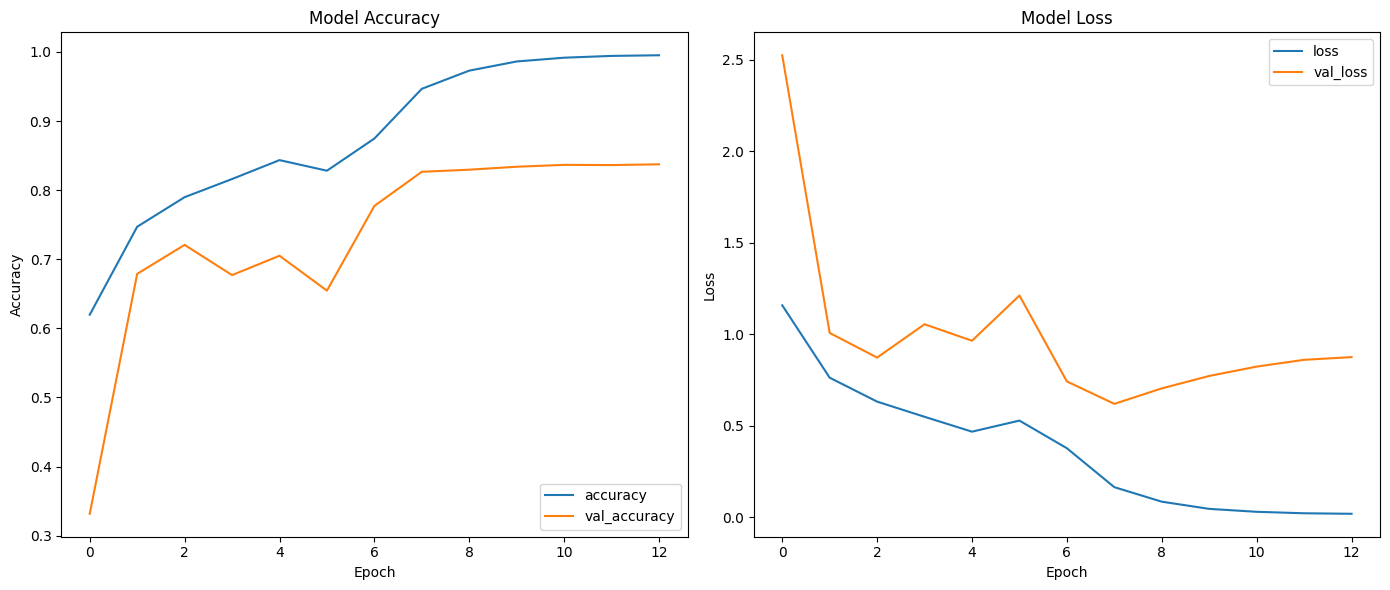

In [20]:
plot_training_history(history)

In [21]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print("=====================================")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9787 - loss: 0.0737
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8280 - loss: 0.6230

Train Loss: 0.07430759072303772
Train Accuracy: 0.9784600138664246
-------------------------------------
Test Loss: 0.6193431615829468
Test Accuracy: 0.8266000151634216


---
### 5차 모델링
- Dropout Layer 추가 (과적합 방지)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 레이어 추가
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3)) # Dropout Layer 추가
model.add(layers.Dense(10, activation='softmax'))

# 사전 훈련된 층 모두 학습
for layer in base_model.layers:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ModelCheckpoint 설정
checkpoint = ModelCheckpoint('best_resnet50_cifar10_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# 학습률 스케줄링 설정
def lr_schedule(epoch, lr):
    if epoch > 5:
        return lr * 0.5  # 에포크 5 이후 학습률을 절반으로 줄임
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# 모델 학습
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, lr_scheduler])

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 118s 85ms/step - accuracy: 0.5040 - loss: 1.6362 - val_accuracy: 0.2847 - val_loss: 2.2513 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 52ms/step - accuracy: 0.6555 - loss: 1.0247 - val_accuracy: 0.5763 - val_loss: 1.3040 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7258 - loss: 0.8277 - val_accuracy: 0.4742 - val_loss: 1.8158 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.7527 - loss: 0.7484 - val_accuracy: 0.4890 - val_loss: 1.8752 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.7619 - loss: 0.7206 - val_accuracy: 0.5441 - val_loss: 1.4182 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - accuracy: 0.7550 - loss: 0.7433 - val_accuracy: 0.6553 - val_loss: 1.1132 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 55ms/step - accuracy: 0.8285 - 

### 5차 모델링 결과

In [26]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,819,552 (281.60 MB)

 Trainable params: 24,588,810 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,177,622 (187.60 MB)

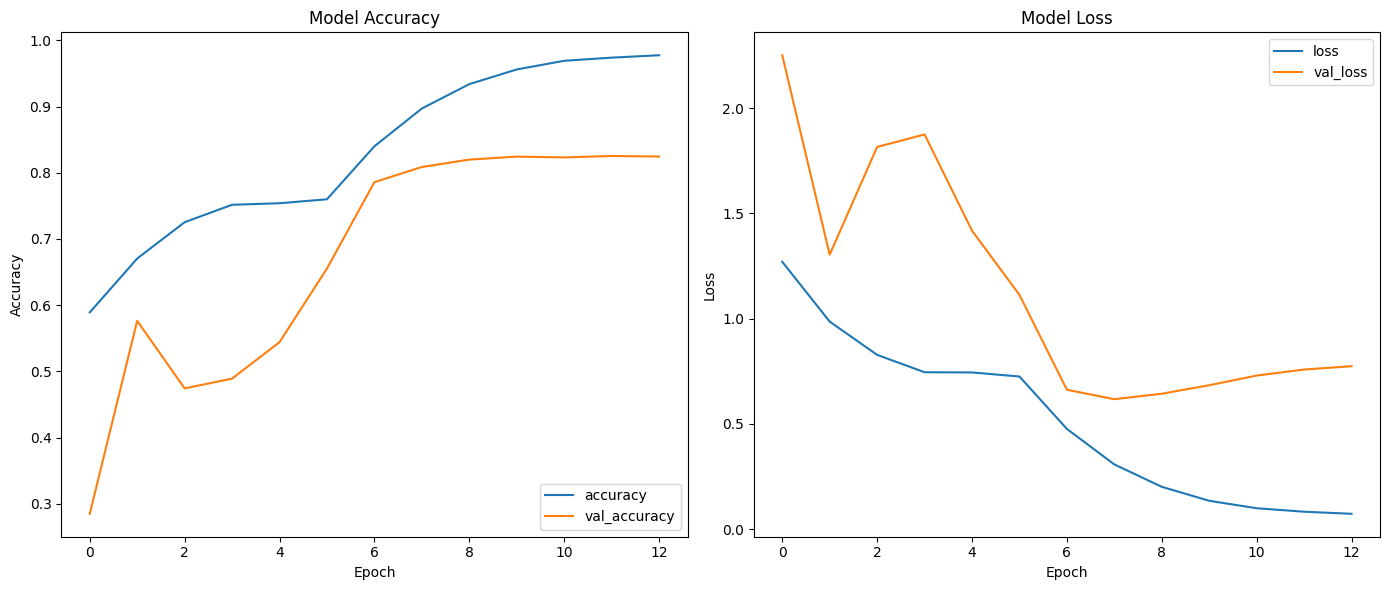

In [27]:
plot_training_history(history)

In [28]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print("=====================================")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9269 - loss: 0.2184
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8093 - loss: 0.6187

Train Loss: 0.21848158538341522
Train Accuracy: 0.9266600012779236
-------------------------------------
Test Loss: 0.6178570985794067
Test Accuracy: 0.8087999820709229
